In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
# CSV functions
def csv_to_dict(file):
    """
    read CSV file and create dict with key for each head containing a list of column entries for respective head
    
    :param file: path to CSV file to read
    :return: created dictionary
    """
    d = {}
    with open(file) as fin:
        reader = csv.reader(fin)
        headers = next(reader, None)
        for h in headers:
            d[h] = []
        for row in reader:
            for h, entry in zip(headers,row):
                d[h].append(entry)
    return d


def print_csv_dict(d):
    """
    print CSV dictionary in formatted way
    
    :param d: dict of CSV file to print
    :return:
    """
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(d)

In [3]:
# IMU data dict functions
def extract_acc(d):
    """
    extract acceleration vectors for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: acc_x, acc_y, acc_z (numpy arrays)
    """
    acc_x = np.array(d['arx'], dtype='float32')
    acc_y = np.array(d['ary'], dtype='float32')
    acc_z = np.array(d['arz'], dtype='float32')
    return acc_x, acc_y, acc_z


def extract_corr_acc(d):
    """
    extract corrected acceleration vectors for IMU data run dict (subtracted gravity average)
    
    :param d: dict of CSV file of IMU data run
    :return: acc_cx, acc_cy, acc_cz (numpy arrays)
    """
    acc_cx = np.array(d['acx'], dtype='float32')
    acc_cy = np.array(d['acy'], dtype='float32')
    acc_cz = np.array(d['acz'], dtype='float32')
    return acc_cx, acc_cy, acc_cz

In [4]:
# read all IMU files
imu_data = []
for orientation in range(5):
    orientation_data = []
    for run in range(5):
        run_name = 'run' + str(orientation + 1) + str(run + 1)
        run_data_file = 'IMU_data_orientations/orientation' + str(orientation + 1) + '/imu1_' + run_name + '_data.csv'
        run_dict = csv_to_dict(run_data_file)
        orientation_data.append(run_dict)
    imu_data.append(orientation_data)

In [5]:
# for each run compute summary including average and standard deviation for each axis
imu_sum = []
for orientation in range(5):
    orientation_data = imu_data[orientation]
    orientation_sum = []
    for run in range(5):
        run_dict = orientation_data[run]
        run_sum = []
        acc_x, acc_y, acc_z = extract_acc(run_dict)
        
        mean_x = np.mean(acc_x)
        std_x = np.std(acc_x)
        mean_y = np.mean(acc_y)
        std_y = np.std(acc_y)
        mean_z = np.mean(acc_z)
        std_z = np.std(acc_z)
        
        means = [mean_x, mean_y, mean_z]
        stds = [std_x, std_y, std_z]
        run_sum.append(means)
        run_sum.append(stds)
        orientation_sum.append(run_sum)
    sum_file = 'IMU_data_orientations/orientation' + str(orientation + 1) + '/summary.csv'
    with open(sum_file, 'w') as f:
        f.write('acc_x_avg, acc_x_std, acc_y_avg, acc_y_std, acc_z_avg, acc_z_std\n')
        for run in range(5):
            run_sum = orientation_sum[run]
            means = run_sum[0]
            stds = run_sum[1]
            line = ','.join(map(str, [means[0], stds[0], means[1], stds[1], means[2], stds[2]])) + '\n'
            f.write(line)
    imu_sum.append(orientation_sum)

In [6]:
# expected values for each orientation
a = 9.81/np.sqrt(2)
orientation_exps = [(0.0, 0.0, 9.81),
                    (0.0, a, a),
                    (0.0, 9.81, 0.0),
                    (9.81, 0.0, 0.0),
                    (-9.81, 0.0, 0.0)]

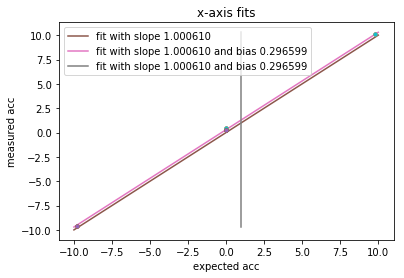

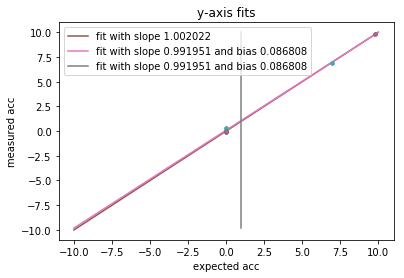

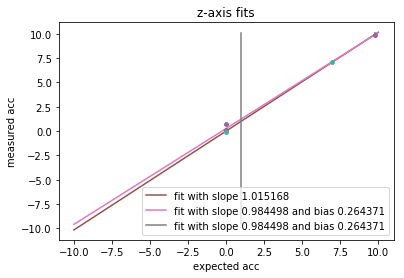

In [34]:
# fits and plots
axes = ['x', 'y', 'z']
for ax in range(3):
    x = []
    y = []
    for orientation in range(5):
        orientation_sum = imu_sum[orientation]
        exp = orientation_exps[orientation][ax]
        for run in range(5):
            run_sum = orientation_sum[run]
            mean = run_sum[0][ax]
            std = run_sum[1][ax]
            x.append(exp)
            y.append(mean)
            plt.errorbar(exp, mean, yerr=std, fmt='.')
    x = np.array(x)
    y = np.array(y)
    x = np.expand_dims(x, axis=-1)
    y = np.expand_dims(y, axis=-1)
    
    # fit just slope
    w = np.linalg.lstsq(x, y, rcond=-1)[0]
    
    # fit slope with bias
    x_b = np.hstack([x, np.ones(x.shape)])
    w_b = np.linalg.lstsq(x_b, y, rcond=-1)[0]
    
    # compute prediction in interval -10.0, 10.0
    pred_x = np.linspace(-10.0, 10.0, num=5)
    # compute prediciton without bias
    pred_x = np.expand_dims(pred_x, axis=-1)
    pred_y = np.dot(pred_x, w)
    # compute prediction with bias
    pred_x_b = np.hstack([pred_x, np.ones(pred_x.shape)])
    pred_y_b = np.dot(pred_x_b, w_b)
    
    # generate plots for both fits
    plt.plot(pred_x, pred_y, '-', label='fit with slope %f'% w)    
    plt.plot(pred_x, pred_y_b, '-', label='fit with slope %f and bias %f' % (w_b[0][0], w_b[1][0]))
    plt.legend()
    plt.xlabel('expected acc')
    plt.ylabel('measured acc')
    plt.title(axes[ax] + '-axis fits')
    plt.show()